# CS 229 Final Project

Authors: Imogen Gardiner, Zofia Dudek, Galen Topper

## Project Overview:

Our project involves building machine learning models to improve the prediction of progression of breast cancer.

In [27]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import roc_auc_score, mean_squared_error
import numpy as np
from xgboost import XGBRegressor, XGBClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

from utils import datasets, train_and_eval_model, run_hparam_search


#### Processing the data

In [2]:
# Read in the dataset
bc_data = pd.read_csv('breast_msk_2018_clinical_data.tsv', sep='\t') 
cnv_df = pd.read_csv("breast_msk_2018_segments.seg", sep="\t") 
print(bc_data.head())
print(cnv_df.head())
# change

          Study ID Patient ID          Sample ID    Cancer Type  \
0  breast_msk_2018  P-0000004  P-0000004-T01-IM3  Breast Cancer   
1  breast_msk_2018  P-0000012  P-0000012-T02-IM3  Breast Cancer   
2  breast_msk_2018  P-0000015  P-0000015-T01-IM3  Breast Cancer   
3  breast_msk_2018  P-0000041  P-0000041-T01-IM3  Breast Cancer   
4  breast_msk_2018  P-0000057  P-0000057-T01-IM3  Breast Cancer   

                        Cancer Type Detailed  Disease Free Event  \
0           Breast Invasive Ductal Carcinoma                   1   
1           Breast Invasive Ductal Carcinoma                   0   
2           Breast Invasive Ductal Carcinoma                   1   
3           Breast Invasive Ductal Carcinoma                   1   
4  Breast Mixed Ductal and Lobular Carcinoma                   1   

   Disease Free (Months) ER PCT Primary ER Status of Sequenced Sample  \
0                    1.1             70                      Positive   
1                  218.0              0   

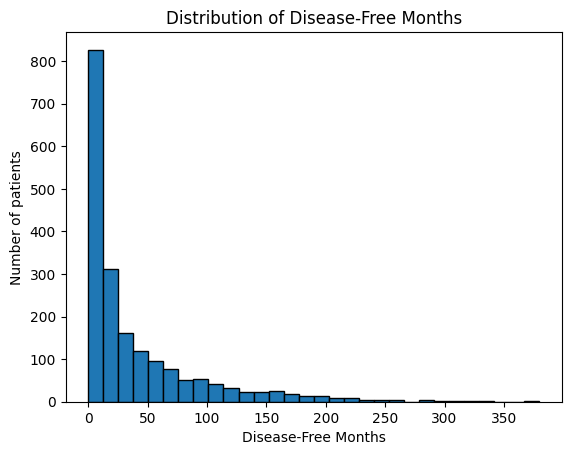

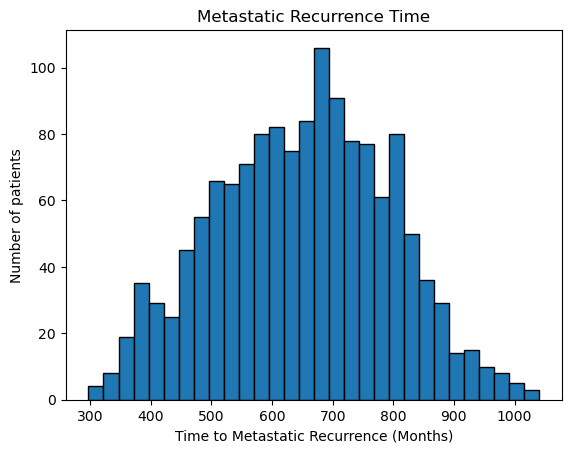

In [3]:
# Visualize the data

# Disease-free months
plt.hist(bc_data['Disease Free (Months)'], bins=30, edgecolor='black')
plt.xlabel('Disease-Free Months')
plt.ylabel('Number of patients')
plt.title('Distribution of Disease-Free Months')
plt.show()

# Metastatic recurrence time
plt.hist(bc_data['Metastatic Recurrence Time'], bins=30, edgecolor='black')
plt.xlabel('Time to Metastatic Recurrence (Months)')
plt.ylabel('Number of patients')
plt.title('Metastatic Recurrence Time')
plt.show()


In [4]:
# Split data into train, valid, test sets

train_idx, valid_idx, test_idx = None, None, None 

train_idx, test_idx = train_test_split(bc_data.index, test_size=0.2, train_size=0.8, random_state=0, shuffle=True, stratify=None)
train_idx, valid_idx = train_test_split(train_idx, test_size=0.2, train_size=0.8, random_state=0, shuffle=True, stratify=None)

In [5]:
# Now, split up features and labels
ds_instance = datasets(
    train_X = bc_data.loc[train_idx],
    valid_X = bc_data.loc[valid_idx],
    test_X = bc_data.loc[test_idx],
    train_y = bc_data.loc[train_idx, "Metastatic Recurrence Time"],
    valid_y = bc_data.loc[valid_idx, "Metastatic Recurrence Time"],
    test_y = bc_data.loc[test_idx, "Metastatic Recurrence Time"],
    )

# Preprocess the data

#### Training a linear regression model

In [6]:
# Extract genomic features
# Constants
TOTAL_GENOME_LENGTH = 3_200_000_000  # Approximate human genome size in base pairs

# Extract Total number of segments per sample
segments_per_sample = cnv_df.groupby("ID").size().reset_index(name="total_segments")

# Compute Proportion of genome affected per sample
cnv_df["segment_length"] = cnv_df["loc.end"] - cnv_df["loc.start"]
cnv_affected_length = cnv_df.groupby("ID")["segment_length"].sum().reset_index()
cnv_affected_length["proportion_genome_affected"] = cnv_affected_length["segment_length"] / TOTAL_GENOME_LENGTH

# Compute Mean CNV per chromosome per sample
mean_cnv_per_chromosome = cnv_df.groupby(["ID", "chrom"])["seg.mean"].mean().unstack().reset_index()
mean_cnv_per_chromosome.columns = ["ID"] + [f"mean_cnv_chr{c}" for c in mean_cnv_per_chromosome.columns[1:]]


# Merge extracted features
genomic_features = segments_per_sample

genomic_features = genomic_features.merge(cnv_affected_length[["ID", "proportion_genome_affected"]], on="ID")
genomic_features = genomic_features.merge(mean_cnv_per_chromosome, on="ID")

# Merge with clinical table
merged_data = bc_data.merge(genomic_features, left_on="Sample ID", right_on="ID", how="left").drop(columns=["ID"])

# Save the merged dataset
merged_data.to_csv("merged_clinical_genomic_data.csv", index=False)

# Display results
print(merged_data.head())

          Study ID Patient ID          Sample ID    Cancer Type  \
0  breast_msk_2018  P-0000004  P-0000004-T01-IM3  Breast Cancer   
1  breast_msk_2018  P-0000012  P-0000012-T02-IM3  Breast Cancer   
2  breast_msk_2018  P-0000015  P-0000015-T01-IM3  Breast Cancer   
3  breast_msk_2018  P-0000041  P-0000041-T01-IM3  Breast Cancer   
4  breast_msk_2018  P-0000057  P-0000057-T01-IM3  Breast Cancer   

                        Cancer Type Detailed  Disease Free Event  \
0           Breast Invasive Ductal Carcinoma                   1   
1           Breast Invasive Ductal Carcinoma                   0   
2           Breast Invasive Ductal Carcinoma                   1   
3           Breast Invasive Ductal Carcinoma                   1   
4  Breast Mixed Ductal and Lobular Carcinoma                   1   

   Disease Free (Months) ER PCT Primary ER Status of Sequenced Sample  \
0                    1.1             70                      Positive   
1                  218.0              0   

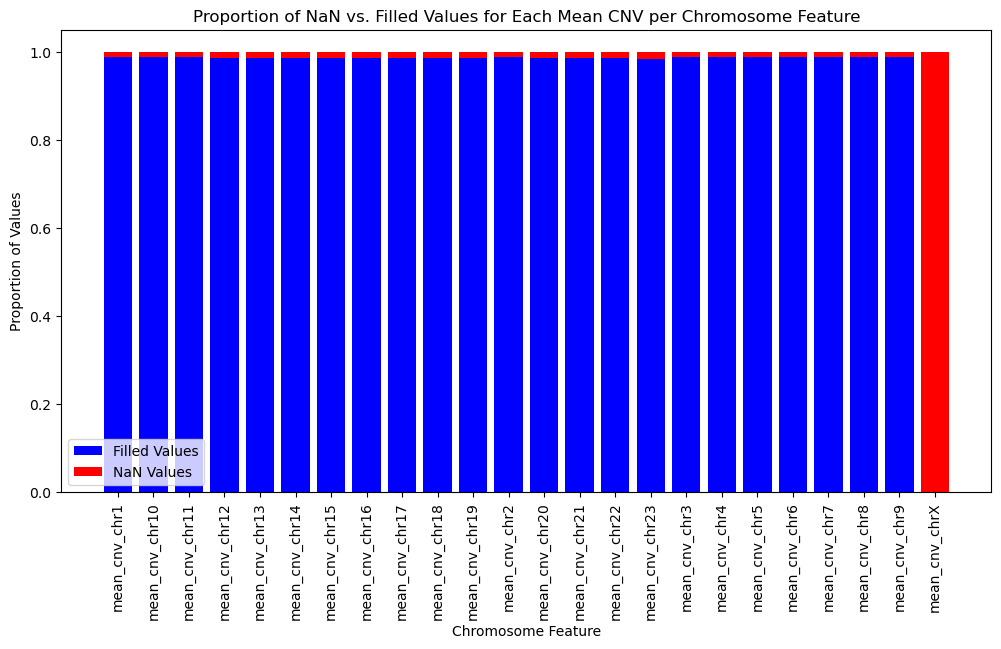

In [7]:
# Select only the mean_cnv_chr columns
mean_cnv_columns = merged_data.filter(like="mean_cnv_chr")

# Set up the figure
plt.figure(figsize=(12, 6))

# Loop through each column and plot its proportion of NaN vs. filled values
for column in mean_cnv_columns.columns:
    nan_count = mean_cnv_columns[column].isna().sum()
    filled_count = mean_cnv_columns[column].notna().sum()
    total = nan_count + filled_count

    # Bar chart for each feature
    plt.bar(column, filled_count / total, color="blue", label="Filled Values" if column == mean_cnv_columns.columns[0] else "")
    plt.bar(column, nan_count / total, bottom=filled_count / total, color="red", label="NaN Values" if column == mean_cnv_columns.columns[0] else "")

# Formatting
plt.xticks(rotation=90)  # Rotate x labels for better readability
plt.xlabel("Chromosome Feature")
plt.ylabel("Proportion of Values")
plt.title("Proportion of NaN vs. Filled Values for Each Mean CNV per Chromosome Feature")
plt.legend()
plt.show()

### Linear Regression Model

In [15]:
y = merged_data["Metastatic Recurrence Time"].dropna() 
X = merged_data

# Remove the target variable from features
X = X.drop(columns=["Metastatic Recurrence Time"], errors="ignore")

# Align X and y
X = X.loc[y.index].reset_index(drop=True) 
y = y.reset_index(drop=True)

# Encode categorical variables
categorical_columns = X.select_dtypes(include=["object"]).columns
encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
X[categorical_columns] = encoder.fit_transform(X[categorical_columns])

# Ensure all remaining features are numeric
X = X.apply(pd.to_numeric, errors='coerce')

# Features (remove unnecessary columns),
X = X.drop(columns=["Metastatic Disease at Last Follow-up", #overlap with target
"Study ID", "Patient ID", "Sample ID", # IDs not useful for prediction
"Last Communication Contact", # Metadata
"Patient's Vital Status", # More of an outcome variable than predictive feature and may overlap with target "Somatic Status"
"Number of Samples Per Patient", # No direct predictive value, could introduce noise
"NGS Sample Collection Time Period", # Logisitcal metadata
"Overall Survival (Months)", # More of an outcome variable than predictive feature, may overlap with "Overall Survival Status"
"Time To Death (Months)", # Outcome feature and potential overlap with target
"mean_cnv_chrX" # Mostly Nan values
])

# Define function to perform hyperparameter tuning for linear regression using GridSearchCV
def hyperparameter_search_linear(X_train, y_train, param_grid, inner_cv):
    model = Pipeline([
        ("scaler", StandardScaler()),  
        ("feature_selection", SelectKBest(score_func=f_regression)),  
        ("regressor", Ridge())  # Default to Ridge, change to Lasso if needed
    ])

    search = GridSearchCV(model, param_grid, cv=inner_cv, scoring="neg_root_mean_squared_error", n_jobs=-1)
    search.fit(X_train, y_train)

    return {"best_params": search.best_params_, "best_score": -search.best_score_} # convert negative RMSE to RMSE

param_grid = {
    "feature_selection__k": [10, 15, 20, 25, 30, 35, 40, 45, 50, 55],  
    "regressor": [Ridge(), Lasso(alpha=10, max_iter=5000)],  
    "regressor__alpha": [0.001, 0.01, 0.1, 1, 10, 100, 500, 1000]  
}

hyperparam_results = {}  # Dictionary to store RMSE for (k, alpha) pairs

kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_train_scores = []
rmse_test_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Ensure all values are numeric
    X_train = pd.DataFrame(X_train).apply(pd.to_numeric, errors='coerce')
    X_test = pd.DataFrame(X_test).apply(pd.to_numeric, errors='coerce')
    y_train = pd.to_numeric(y_train, errors='coerce')

    # Perform mean imputation of missing values
    imputer = SimpleImputer(strategy="mean")
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)

    # Convert back to df 
    X_train = pd.DataFrame(X_train, columns=X.columns)
    X_test = pd.DataFrame(X_test, columns=X.columns)

    # Apply mean imputation to the target variable
    y_train = imputer.fit_transform(y_train.values.reshape(-1, 1)).flatten()

    # Standardize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Conduct hyperparameter tuning using inner cross-validation
    search_results = hyperparameter_search_linear(X_train, y_train, param_grid, inner_cv=5)
    best_params = search_results["best_params"]
    print(f"Best Params (Inner CV): {best_params}, Best Validation RMSE: {search_results['best_score']:.4f}")

    # Use SelectKBest with best k found during hyperparameter search
    selector = SelectKBest(score_func=f_regression, k=best_params["feature_selection__k"])
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)
    selected_features = X.columns[selector.get_support()]
    print(f"Top {best_params['feature_selection__k']} selected features: {list(selected_features)}")

    # Train model with best hyperparameters from search
    best_model = best_params["regressor"].set_params(alpha=best_params["regressor__alpha"])
    best_model.fit(X_train_selected, y_train)

    # Predict on selected features
    y_train_pred = best_model.predict(X_train_selected)
    y_test_pred = best_model.predict(X_test_selected)

    # Evaluate RMSE
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_train_scores.append(train_rmse)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    rmse_test_scores.append(test_rmse)

    # Store RMSE in dict
    hyperparam_results[(best_params["feature_selection__k"], best_params["regressor__alpha"])] = test_rmse

    print(f"Training RMSE: {train_rmse:.4f}")
    print(f"Test RMSE: {test_rmse:.4f}")
    
# Report final results
print(f"Mean Train RMSE: {np.mean(rmse_train_scores):.4f}")
print(f"Mean Test RMSE: {np.mean(rmse_test_scores):.4f}")

/Users/imogengardiner/anaconda3/envs/202env/lib/python3.9/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Params (Inner CV): {'feature_selection__k': 10, 'regressor': Ridge(), 'regressor__alpha': 0.001}, Best Validation RMSE: 0.2903
Top 10 selected features: ['Disease Free (Months)', 'HER2 FISH Status (Report and ASCO) of Primary', 'Invasive Carcinoma Diagnosis Age', 'Time to Diagnosis Invasive Carcinoma', 'Menopausal Status At Diagnosis', 'Mutation Count', 'Overall Patient HER2 Status', 'Prior Breast Primary', 'TMB (nonsynonymous)', 'total_segments']
Training RMSE: 0.2866
Test RMSE: 0.3034


/Users/imogengardiner/anaconda3/envs/202env/lib/python3.9/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Params (Inner CV): {'feature_selection__k': 10, 'regressor': Ridge(alpha=0.001), 'regressor__alpha': 0.001}, Best Validation RMSE: 0.2956
Top 10 selected features: ['Disease Free (Months)', 'HER2 IHC Status Primary', 'Invasive Carcinoma Diagnosis Age', 'Time to Diagnosis Invasive Carcinoma', 'M Stage', 'Menopausal Status At Diagnosis', 'Mutation Count', 'Prior Breast Primary', 'T Stage', 'TMB (nonsynonymous)']
Training RMSE: 0.2916
Test RMSE: 0.2804
Best Params (Inner CV): {'feature_selection__k': 10, 'regressor': Ridge(alpha=0.001), 'regressor__alpha': 0.001}, Best Validation RMSE: 0.2925
Top 10 selected features: ['Disease Free (Months)', 'Invasive Carcinoma Diagnosis Age', 'Time to Diagnosis Invasive Carcinoma', 'M Stage', 'Menopausal Status At Diagnosis', 'Mutation Count', 'Prior Breast Primary', 'T Stage', 'TMB (nonsynonymous)', 'total_segments']
Training RMSE: 0.2885
Test RMSE: 0.2922
Best Params (Inner CV): {'feature_selection__k': 10, 'regressor': Ridge(alpha=0.001), 'regr

/Users/imogengardiner/anaconda3/envs/202env/lib/python3.9/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Plot linear regression model 

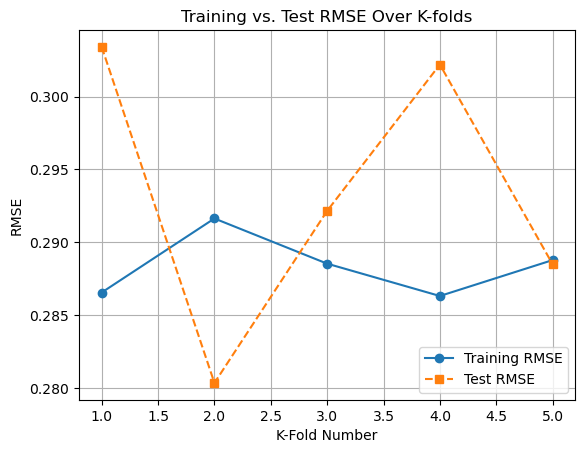

In [16]:
# Create an iteration index (e.g., fold numbers)
iterations = range(1, len(rmse_train_scores) + 1)

# Plot Training RMSE
plt.plot(iterations, rmse_train_scores, label="Training RMSE", marker='o', linestyle='-')

# Plot Test RMSE
plt.plot(iterations, rmse_test_scores, label="Test RMSE", marker='s', linestyle='--')

# Formatting the plot
plt.xlabel("K-Fold Number")
plt.ylabel("RMSE")
plt.title("Training vs. Test RMSE Over K-folds")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

Plot hyperparameter tuning results

/var/folders/q0/j9yz0h6s7g1cm7slf4lg5xsm0000gn/T/ipykernel_98702/727157541.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_scores_sorted.values, y=feature_scores_sorted.index, palette="viridis")


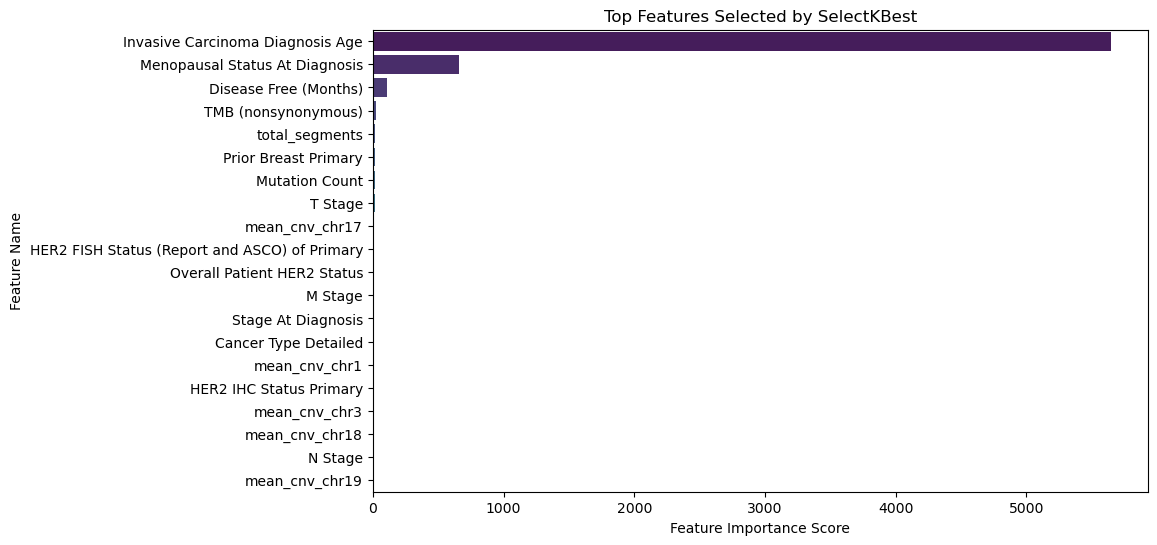

In [14]:
# Convert feature selection results into a dictionary
feature_scores = pd.Series(selector.scores_, index=X.columns)

# Sort features by importance
feature_scores_sorted = feature_scores.nlargest(20)  # Show top 20 features

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_scores_sorted.values, y=feature_scores_sorted.index, palette="viridis")
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature Name")
plt.title("Top Features Selected by SelectKBest")
plt.show()


#### Training an XGBoost model
We have many missing values, which XGBoost can handle well.

Metrics: {'train': 0.45185138266888114, 'valid': 92.33603284407312, 'test': 86.9274697431041}


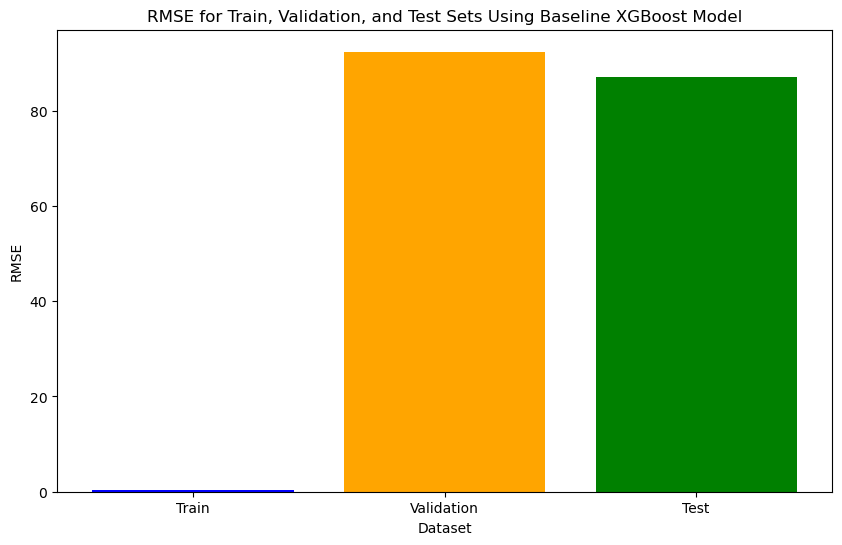

In [17]:
# Handle categorical features
categorical_features = ds_instance.train_X.select_dtypes(include=["object"]).columns

for col in categorical_features:
    ds_instance.train_X[col] = ds_instance.train_X[col].astype("category")
    ds_instance.valid_X[col] = ds_instance.valid_X[col].astype("category")
    ds_instance.test_X[col] = ds_instance.test_X[col].astype("category")

# Define XGBoost model
XGB_model = XGBRegressor(random_state=0, n_estimators=100, learning_rate=0.1, max_depth=5, enable_categorical=True)

# Define features to include 
features_to_include = ["Cancer Type", "Cancer Type Detailed", "Disease Free Event", "Disease Free (Months)", "ER PCT Primary", 
                       "ER Status of Sequenced Sample", "ER Status of the Primary", "Fraction Genome Altered", "HER2 FISH Status of Sequenced Sample", 
                       "HER2 FISH Ratio Value of Sequenced Sample", "HER2 FISH Ratio Primary", "HER2 FISH Status (Report and ASCO) of Primary", 
                       "HER2 IHC Status Primary", "HER2 IHC Score of Sequenced Sample", "HER2 IHC Status of Sequenced Sample", "HER2 IHC Score Primary", 
                       "HER2 Primary Status", "Overall HR Status of Sequenced Sample", "Invasive Carcinoma Diagnosis Age", 
                       "Time to Diagnosis Invasive Carcinoma", "Last Communication Contact", "Primary Tumor Laterality", "M Stage", 
                       "Menopausal Status At Diagnosis", "Metastatic Disease at Last Follow-up", "Mutation Count", 
                       "N Stage", "NGS Sample Collection Time Period", "Oncotree Code", "Overall Survival (Months)", "Overall Survival Status", 
                       "Overall HER2 Status of Sequenced Sample", "Overall Patient HER2 Status", "Overall Patient HR Status", 
                       "Overall Patient Receptor Status", "Overall Primary Tumor Grade", "PR PCT Primary", "PR Status of Sequenced Sample", 
                       "PR Status of the Primary", "Primary Nuclear Grade", "Prior Breast Primary", "Prior Local Recurrence", "Receptor Status Primary", 
                       "Number of Samples Per Patient", "Site of Sample", "Sample Type", "Sex", "Somatic Status", "Stage At Diagnosis", "T Stage", 
                       "Time To Death (Months)", "TMB (nonsynonymous)", "Tumor Sample Histology", "Tumor Tissue Origin", "Patient's Vital Status"]

# Remove rows with NaN values in the features to include
ds_instance.train_X = ds_instance.train_X[features_to_include].dropna()
ds_instance.valid_X = ds_instance.valid_X[features_to_include].dropna()
ds_instance.test_X = ds_instance.test_X[features_to_include].dropna()

# Ensure the target variable has no NaN values
ds_instance.train_y = ds_instance.train_y[ds_instance.train_X.index]
ds_instance.valid_y = ds_instance.valid_y[ds_instance.valid_X.index]
ds_instance.test_y = ds_instance.test_y[ds_instance.test_X.index]

# Train and evaluate XGBoost model
predictions, metrics = train_and_eval_model(model=XGB_model, ds=ds_instance, features_to_include=features_to_include)

# Report metrics
print("Metrics:", metrics)

# Plot metrics
# Extract the metrics
train_rmse = metrics['train']
valid_rmse = metrics['valid']
test_rmse = metrics['test']

# Create a bar plot
labels = ['Train', 'Validation', 'Test']
rmse_values = [train_rmse, valid_rmse, test_rmse]

plt.figure(figsize=(10, 6))
plt.bar(labels, rmse_values, color=['blue', 'orange', 'green'])
plt.xlabel('Dataset')
plt.ylabel('RMSE')
plt.title('RMSE for Train, Validation, and Test Sets Using Baseline XGBoost Model')
plt.show()

#### Addressing overfitting
To address overfitting, we will run a hyperparameter search and retrain the model on the best hyperparameters found.

In [36]:
from utils import run_hparam_search

# Remove categorical features from the dataset (TODO: figure out how to handle categorical features)
ds_instance.train_X = ds_instance.train_X.select_dtypes(include=["int", "float", "bool"])
ds_instance.valid_X = ds_instance.valid_X.select_dtypes(include=["int", "float", "bool"])
ds_instance.test_X = ds_instance.test_X.select_dtypes(include=["int", "float", "bool"])

# Update features_to_include to only include numerical features
features_to_include = ds_instance.train_X.columns.tolist()

print(len(features_to_include))

import xgboost
print(xgboost.__version__)

# Run a hyperparameter search
best_metrics, best_params = run_hparam_search(ds=ds_instance, features_to_include=features_to_include, max_depth_options=[1, 2, 3], 
                                              learning_rate_options=[0.001, 0.01, 0.1, 0.2, 0.3], n_estimators_options=[2, 5, 10, 25, 50])

# Report best hyperparameters and model performance
print("Best Hyperparameters Found:", best_params)
print("Best Metrics Found:", best_metrics)


12
2.1.1


TypeError: xgboost.sklearn.XGBRegressor() got multiple values for keyword argument 'enable_categorical'

#### Training a Random Survival Forest Model


Overall Survival - Concordance index: 0.889


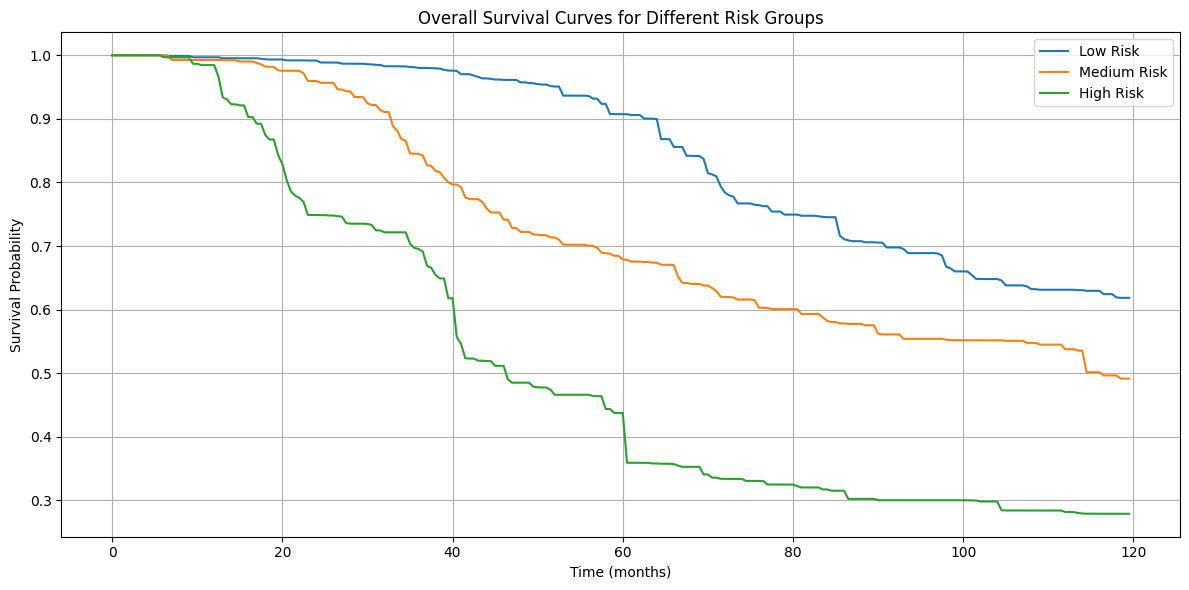

Metastasis Prediction - Accuracy: 0.997

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       103
           1       1.00      1.00      1.00       281

    accuracy                           1.00       384
   macro avg       1.00      1.00      1.00       384
weighted avg       1.00      1.00      1.00       384



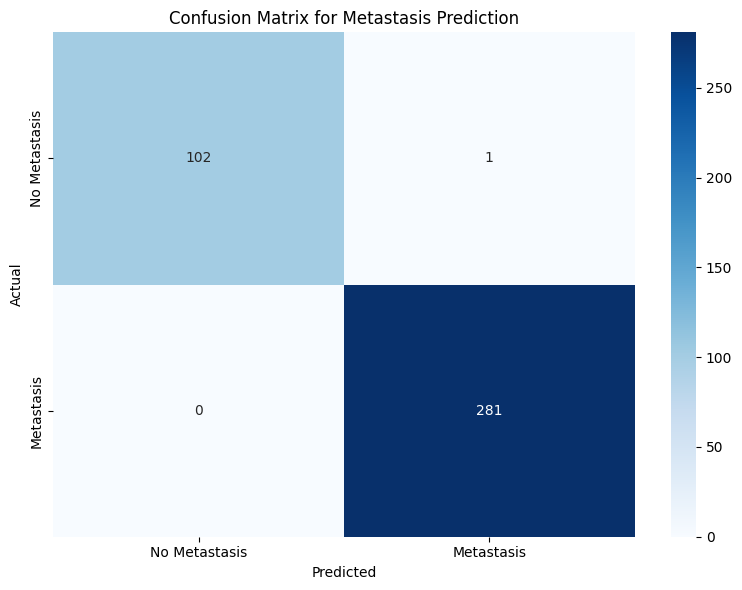

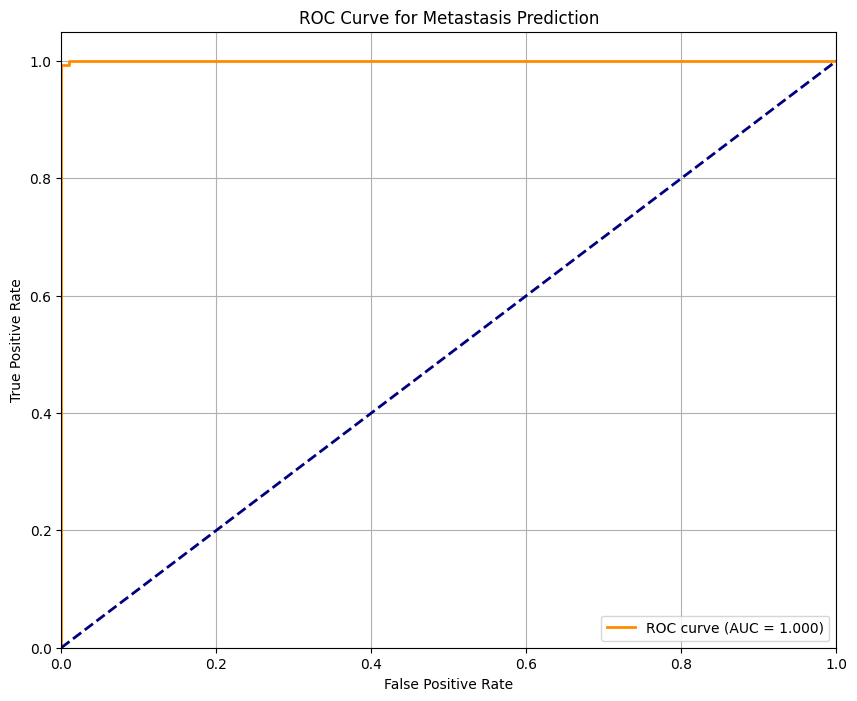

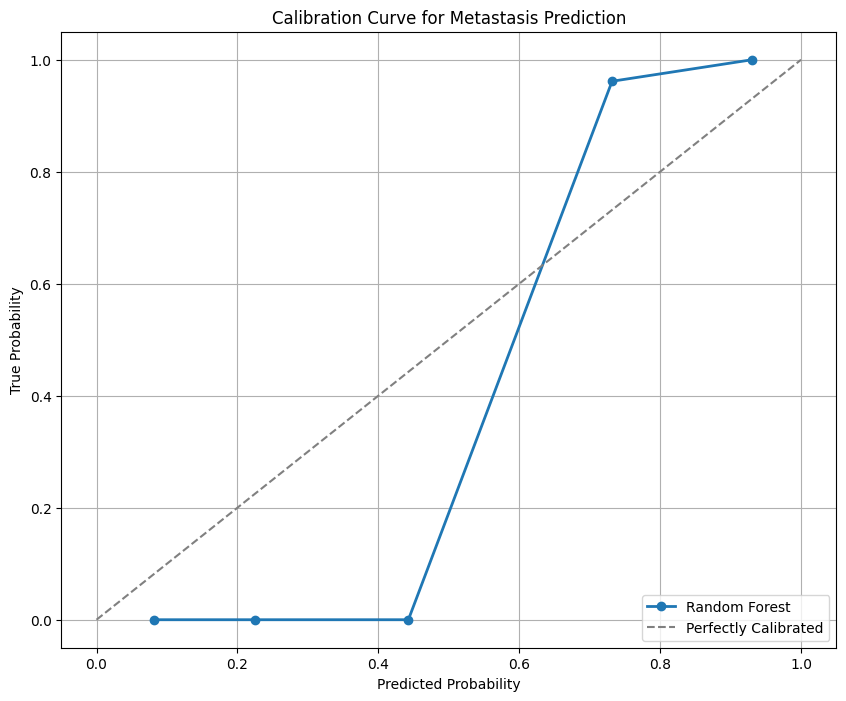

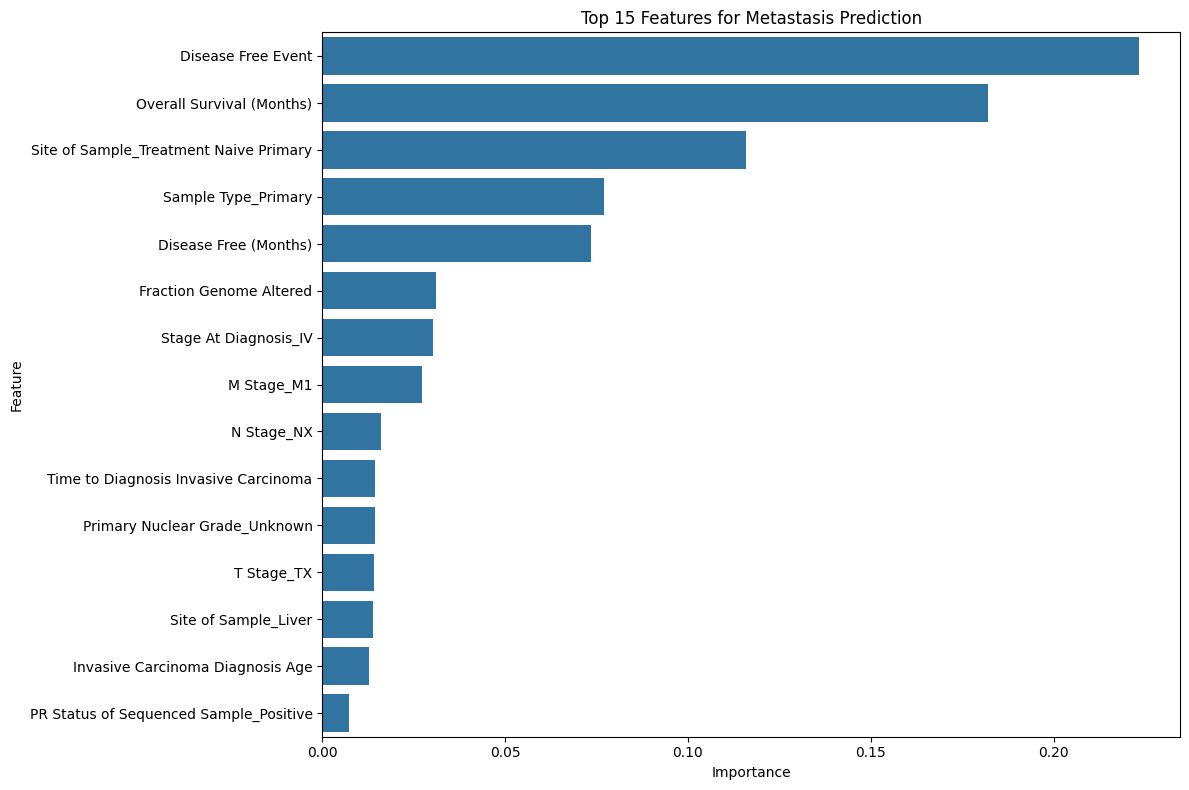


Cross-validation Results:
Overall Survival CV concordance index: 0.868 ± 0.012
Metastasis CV ROC-AUC: 1.000 ± 0.000


In [21]:
#### Training Survival and Classification Models for Cancer Outcomes

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, accuracy_score
from sklearn.calibration import calibration_curve

# Define features to include
features_to_include = [
    "Cancer Type", "Cancer Type Detailed", "Disease Free Event", "Disease Free (Months)", "ER PCT Primary", 
    "ER Status of Sequenced Sample", "ER Status of the Primary", "Fraction Genome Altered", "HER2 FISH Status of Sequenced Sample", 
    "HER2 FISH Ratio Value of Sequenced Sample", "HER2 FISH Ratio Primary", "HER2 FISH Status (Report and ASCO) of Primary", 
    "HER2 IHC Status Primary", "HER2 IHC Score of Sequenced Sample", "HER2 IHC Status of Sequenced Sample", "HER2 IHC Score Primary", 
    "HER2 Primary Status", "Overall HR Status of Sequenced Sample", "Invasive Carcinoma Diagnosis Age", 
    "Time to Diagnosis Invasive Carcinoma", "Last Communication Contact", "Primary Tumor Laterality", "M Stage", 
    "Menopausal Status At Diagnosis", "Mutation Count", 
    "N Stage", "NGS Sample Collection Time Period", "Oncotree Code", "Overall Survival (Months)", 
    "Overall HER2 Status of Sequenced Sample", "Overall Patient HER2 Status", "Overall Patient HR Status", 
    "Overall Patient Receptor Status", "Overall Primary Tumor Grade", "PR PCT Primary", "PR Status of Sequenced Sample", 
    "PR Status of the Primary", "Primary Nuclear Grade", "Prior Breast Primary", "Prior Local Recurrence", "Receptor Status Primary", 
    "Number of Samples Per Patient", "Site of Sample", "Sample Type", "Sex", "Somatic Status", "Stage At Diagnosis", "T Stage", 
    "TMB (nonsynonymous)", "Tumor Sample Histology", "Tumor Tissue Origin"
]

# 1. Load the data
data = pd.read_csv('breast_msk_2018_clinical_data.tsv', sep='\t')

#####################################
### PART 1: OVERALL SURVIVAL PREDICTION (SURVIVAL ANALYSIS)
#####################################

# 2a. Prepare the overall survival outcome
y_os = np.array(
    [(str(status).strip().lower() == "deceased", float(time))
     for status, time in zip(data["Patient's Vital Status"], data["Overall Survival (Months)"])],
    dtype=[("event", "bool"), ("time", "float")]
)

# 3a. Filter out rows with missing survival data
valid_os_indices = ~np.isnan(data["Overall Survival (Months)"])
y_os = y_os[valid_os_indices]
data_os = data.loc[valid_os_indices]

# 4a. Prepare the feature matrix for survival analysis
X_os = data_os[features_to_include]

# 5a. Convert categorical features to numerical representations
X_os = pd.get_dummies(X_os, drop_first=True)

# 6a. Handle missing values
X_os = X_os.fillna(X_os.median())

# 7a. Split the data for survival analysis
X_train_os, X_test_os, y_train_os, y_test_os = train_test_split(X_os, y_os, test_size=0.2, random_state=42)

# 8a. Build and train the Random Survival Forest model
rsf_os = RandomSurvivalForest(
    n_estimators=200,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features="sqrt",
    max_depth=None,
    n_jobs=-1,
    random_state=42
)
rsf_os.fit(X_train_os, y_train_os)

# 9a. Evaluate the survival model
c_index_os = concordance_index_censored(y_test_os["event"], y_test_os["time"], rsf_os.predict(X_test_os))
print(f"Overall Survival - Concordance index: {c_index_os[0]:.3f}")

# 10a. Plot survival curves for different risk groups
test_pred_os = rsf_os.predict(X_test_os)
risk_scores_os = pd.Series(test_pred_os)
risk_groups_os = pd.qcut(risk_scores_os, 3, labels=['Low Risk', 'Medium Risk', 'High Risk'])

# Setup figure for overall survival
plt.figure(figsize=(12, 6))
times = np.arange(0, 120, 0.5)  # 0 to 10 years in months

for risk_group in ['Low Risk', 'Medium Risk', 'High Risk']:
    indices = np.where(risk_groups_os == risk_group)[0]
    
    if len(indices) > 0:  # Make sure there are samples in this group
        sample_idx = indices[0]
        patient_features = X_test_os.iloc[sample_idx:sample_idx+1]
        
        # Predict and plot survival curve
        survival_func = rsf_os.predict_survival_function(patient_features)[0]
        survival_probs = survival_func(times)
        
        plt.plot(times, survival_probs, label=f"{risk_group}")

plt.xlabel('Time (months)')
plt.ylabel('Survival Probability')
plt.title('Overall Survival Curves for Different Risk Groups')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#####################################
### PART 2: METASTASIS PREDICTION (BINARY CLASSIFICATION)
#####################################

# 2b. Prepare data for metastasis classification
# Convert to binary outcome (Yes/No for metastasis)
data['metastasis_binary'] = data["Metastatic Disease at Last Follow-up"].map(
    lambda x: 1 if str(x).strip().lower() == "yes" else 0
)

# 3b. Filter out rows with missing metastasis data
valid_met_indices = ~data['metastasis_binary'].isna() 
data_met = data.loc[valid_met_indices]
y_met = data_met['metastasis_binary'].values

# 4b. Prepare features for metastasis prediction
X_met = data_met[features_to_include]

# 5b. Convert categorical features and handle missing values
X_met = pd.get_dummies(X_met, drop_first=True)
X_met = X_met.fillna(X_met.median())

# 6b. Split the data for classification
X_train_met, X_test_met, y_train_met, y_test_met = train_test_split(
    X_met, y_met, test_size=0.2, random_state=42, stratify=y_met
)

# 7b. Build and train the Random Forest classifier
rf_met = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='sqrt',
    bootstrap=True,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)
rf_met.fit(X_train_met, y_train_met)

# 8b. Make predictions
y_pred_proba = rf_met.predict_proba(X_test_met)[:, 1]
y_pred = rf_met.predict(X_test_met)

# 9b. Evaluate the classification model
accuracy = accuracy_score(y_test_met, y_pred)
print(f"Metastasis Prediction - Accuracy: {accuracy:.3f}")
print("\nClassification Report:")
print(classification_report(y_test_met, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test_met, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Metastasis', 'Metastasis'],
            yticklabels=['No Metastasis', 'Metastasis'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Metastasis Prediction')
plt.tight_layout()
plt.show()

# 10b. Plot ROC curve
fpr, tpr, _ = roc_curve(y_test_met, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Metastasis Prediction')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# 11b. Plot probability calibration curve
plt.figure(figsize=(10, 8))
prob_true, prob_pred = calibration_curve(y_test_met, y_pred_proba, n_bins=5)
plt.plot(prob_pred, prob_true, marker='o', linewidth=2, label='Random Forest')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.title('Calibration Curve for Metastasis Prediction')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# 12b. Plot feature importance (top 15 features)
feature_importance = pd.DataFrame({
    'Feature': X_met.columns,
    'Importance': rf_met.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
plt.title('Top 15 Features for Metastasis Prediction')
plt.tight_layout()
plt.show()

# 13. Cross-validation for both models
print("\nCross-validation Results:")
print("========================")

# Overall Survival CV
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_os = []

for train_idx, test_idx in k_fold.split(X_os):
    X_train_cv, X_test_cv = X_os.iloc[train_idx], X_os.iloc[test_idx]
    y_train_cv, y_test_cv = y_os[train_idx], y_os[test_idx]
    
    # Train model
    rsf_cv = RandomSurvivalForest(n_estimators=100, min_samples_split=10, random_state=42)
    rsf_cv.fit(X_train_cv, y_train_cv)
    
    # Predict and evaluate
    pred_cv = rsf_cv.predict(X_test_cv)
    c_index_cv = concordance_index_censored(y_test_cv["event"], y_test_cv["time"], pred_cv)
    cv_scores_os.append(c_index_cv[0])

print(f"Overall Survival CV concordance index: {np.mean(cv_scores_os):.3f} ± {np.std(cv_scores_os):.3f}")

# Metastasis CV
cv_scores_met = cross_val_score(rf_met, X_met, y_met, cv=5, scoring='roc_auc')
print(f"Metastasis CV ROC-AUC: {np.mean(cv_scores_met):.3f} ± {np.std(cv_scores_met):.3f}")

In [ ]:
# Code to evaluate Decision Tree model


In [ ]:
# Code to run a hyperparameter search for the CNN